# Rat OGD Bootstrapping

Teng-Jui Lin

Created: 2023-01-02

Edited: 2023-01-02

Objective: Explore the bootstrapping for reducing biological variability (doi: 10.1038/s41593-022-01167-6).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import vampire as vp
from sklearn import manifold, cluster
from numpy.random import default_rng
from matplotlib import cm

/opt/miniconda3/envs/vampire-analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vp.plot.set_plot_style()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
results_path = r"/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/4-vampire-analysis-data"
model_path = os.path.join(results_path, "model_otsu_(50_5_29)__otsu.pickle")
vampire_model = vp.util.read_pickle(model_path)
property_path = os.path.join(
    results_path, "labeled-apply-properties_otsu_on_otsu_(50_5_29)__.pickle"
)
apply_properties_df = vp.util.read_pickle(property_path)
normalized_contours = np.vstack(apply_properties_df["normalized_contour"].values)

## Color labels

In [30]:
def label_df(properties_df, id_df, target_props, search_prop='filename'):
    """
    properties_df : DataFrame
        Contains "filename" column
    id_df : DataFrame
        Contains columns listed in `properties` and "regex" column.
    target_props : list
        List of property(s) to be added. Must match column name in `id_df`.
    """
    properties_df = properties_df.copy()
    properties_df[target_props] = np.nan
    for i in range(id_df['regex'].size):
        mask = properties_df[search_prop].astype(str).str.contains(id_df['regex'][i], case=False)
        properties_df.loc[mask, target_props] = id_df.iloc[i, :][target_props].values
    return properties_df

In [5]:
data_label_path = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/3-data-labels'

In [10]:
treatment_id_df = pd.read_excel(os.path.join(data_label_path, 'treatment-labels.xlsx'))
treatment_id_df

,treatment,treatment_color,regex
0,NC,#757575,NC
1,OGD 0.5h,#00ACC1,OGD 0.5h
2,OGD 1.5h,#1E88E5,OGD 1.5h
3,OGD 3.0h,#3949AB,OGD 3.0h
4,OGD 0.5h + AZO,#FDD835,AZO
5,OGD 3.0h + SOD,#F4511E,SOD


In [7]:
region_id_df = pd.read_excel(os.path.join(data_label_path, 'region-labels.xlsx'))
region_id_df.head()

,id,region,regex,region_color
0,cortex,Cortex,cortex,#A0C8FA
1,thalamus,Thalamus,thalamus,#F04341
2,hippocampus,Hippocampus,hippocampus,#F0CA07


## Bootstrapping normalized contours per condition before PCA

In [302]:
rng = default_rng(seed=1)
subsample_ratio = 0.3  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_regions = np.unique(apply_properties_df['region'])
num_regions = len(all_regions)
# all_mean_bootstrapped_region_contours = np.zeros((num_regions*num_resample, 100))
all_mean_bootstrapped_region_contours_df = pd.DataFrame({
    'bootstrapped_contours': [],
    'region': [],
})
for n_region, region in enumerate(all_regions):
    region_cond = apply_properties_df['region'] == region
    mean_bootstrapped_region_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(region_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    print(num_subsample)
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_region_contours = rng.choice(normalized_contours[region_cond], size=num_subsample, replace=False)
        mean_bootstrapped_region_contour = bootstrapped_region_contours.mean(axis=0)
        mean_bootstrapped_region_contours[n_resample, :] = mean_bootstrapped_region_contour
    mean_bootstrapped_region_contours_df = pd.DataFrame({
        'bootstrapped_contours': mean_bootstrapped_region_contours.tolist(),
        'region': [region] * num_resample,
    })
    all_mean_bootstrapped_region_contours_df = pd.concat([all_mean_bootstrapped_region_contours_df, mean_bootstrapped_region_contours_df])
all_mean_bootstrapped_region_contours_df = all_mean_bootstrapped_region_contours_df.reset_index()
all_mean_bootstrapped_region_contours_df = label_df(all_mean_bootstrapped_region_contours_df, region_id_df, ['region_color'], 'region')
# PCA bootstrapped contours
all_mean_bootstrapped_region_contours = np.stack(all_mean_bootstrapped_region_contours_df['bootstrapped_contours'].to_numpy())
principal_directions, principal_components, explained_variance = vp.amath.pca(all_mean_bootstrapped_region_contours)
trunc_principal_components = principal_components[:, :num_pc]
explained_variance_ratio = explained_variance / sum(explained_variance)

5247
1608
4411


(0.0, 1.05)

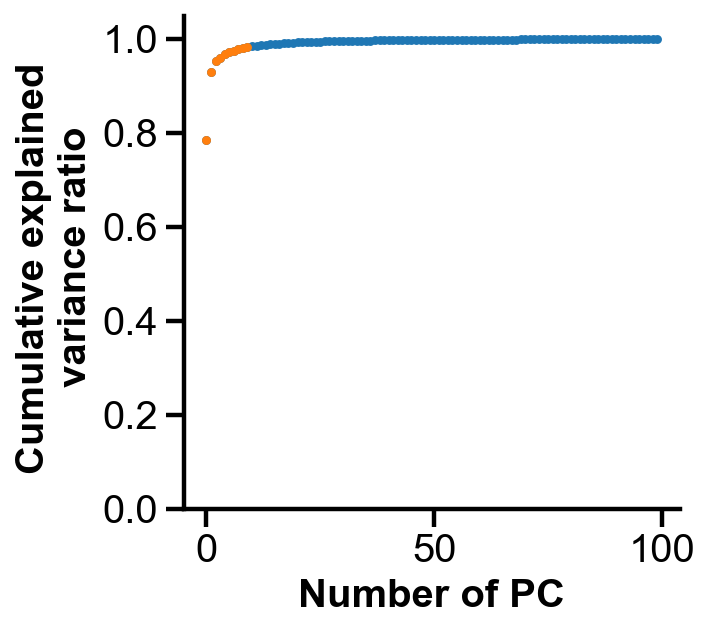

In [303]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.cumsum(explained_variance_ratio), '.')
ax.plot(np.cumsum(explained_variance_ratio)[:10], '.')
ax.set_xlabel('Number of PC')
ax.set_ylabel('Cumulative explained \n variance ratio')
ax.set_ylim(0, 1.05)

Text(0.5, 1.0, 'Rat OGD (x/n = 0.3)')

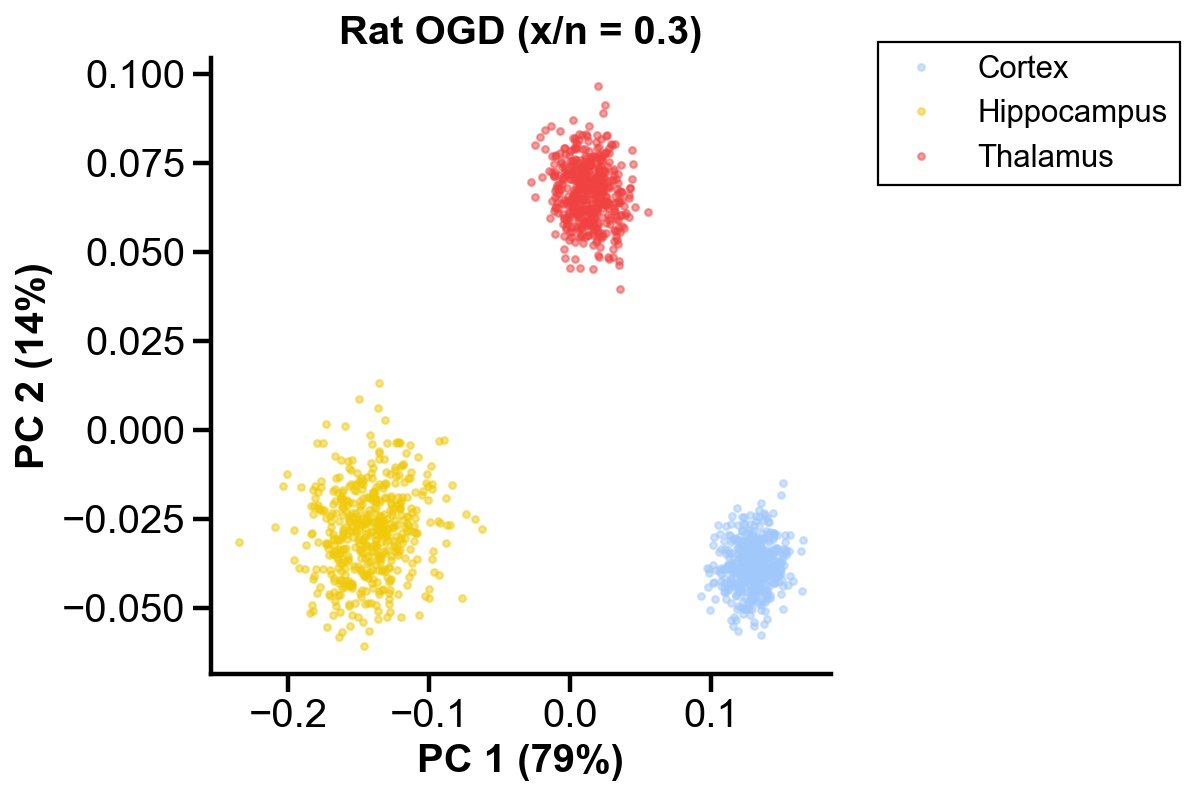

In [304]:
fig, ax = plt.subplots(figsize=(5, 5))
for n_region, region in enumerate(all_regions):
    ax.plot(
        trunc_principal_components[n_region*num_resample:(n_region+1)*num_resample, 0], 
        trunc_principal_components[n_region*num_resample:(n_region+1)*num_resample, 1],
        '.', alpha=0.5,
        c=all_mean_bootstrapped_region_contours_df['region_color'].iloc[n_region*num_resample],
        label=region,
    )
ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_xlabel(f"PC 1 ({round(explained_variance_ratio[0]*100)}%)")
ax.set_ylabel(f"PC 2 ({round(explained_variance_ratio[1]*100)}%)")
ax.set_title(f'Rat OGD (x/n = {subsample_ratio})')

In [305]:
all_treatments

array(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO', 'OGD 1.5h', 'OGD 3.0h',
       'OGD 3.0h + SOD'], dtype=object)

In [257]:
rng = default_rng(seed=1)
subsample_ratio = 0.3  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_treatments = np.unique(apply_properties_df['treatment'])
num_treatments = len(all_treatments)
# all_mean_bootstrapped_treatment_contours = np.zeros((num_treatments*num_resample, 100))
all_mean_bootstrapped_treatment_contours_df = pd.DataFrame({
    'bootstrapped_contours': [],
    'treatment': [],
})
for n_treatment, treatment in enumerate(all_treatments):
    treatment_cond = apply_properties_df['treatment'] == treatment
    mean_bootstrapped_treatment_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(treatment_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_treatment_contours = rng.choice(normalized_contours[treatment_cond], size=num_subsample, replace=False)
        mean_bootstrapped_treatment_contour = bootstrapped_treatment_contours.mean(axis=0)
        mean_bootstrapped_treatment_contours[n_resample, :] = mean_bootstrapped_treatment_contour
    mean_bootstrapped_treatment_contours_df = pd.DataFrame({
        'bootstrapped_contours': mean_bootstrapped_treatment_contours.tolist(),
        'treatment': [treatment] * num_resample,
    })
    all_mean_bootstrapped_treatment_contours_df = pd.concat([all_mean_bootstrapped_treatment_contours_df, mean_bootstrapped_treatment_contours_df])
all_mean_bootstrapped_treatment_contours_df = all_mean_bootstrapped_treatment_contours_df.reset_index()
all_mean_bootstrapped_treatment_contours_df = label_df(all_mean_bootstrapped_treatment_contours_df, treatment_id_df, ['treatment_color'], 'treatment')
# PCA bootstrapped contours
all_mean_bootstrapped_treatment_contours = np.stack(all_mean_bootstrapped_treatment_contours_df['bootstrapped_contours'].to_numpy())
principal_directions, principal_components, explained_variance = vp.amath.pca(all_mean_bootstrapped_treatment_contours)
trunc_principal_components = principal_components[:, :num_pc]
explained_variance_ratio = explained_variance / sum(explained_variance)

In [258]:
all_mean_bootstrapped_treatment_contours.shape

(3000, 100)

(-1.3123166791008412,
 1.3238967179002217,
 -0.7519765706884304,
 0.7407685439862606)

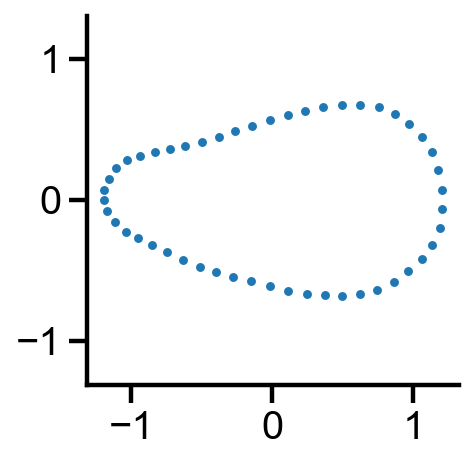

In [259]:
i = 1500
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(
    (all_mean_bootstrapped_treatment_contours)[i, :50],
    (all_mean_bootstrapped_treatment_contours)[i, 50:],
    '.'
)
ax.axis('equal')

In [260]:
np.mean((principal_components @ principal_directions + mean_contour)[i*num_resample:(i+1)*num_resample, :], axis=0).shape

/opt/miniconda3/envs/vampire-analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/vampire-analysis/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(100,)

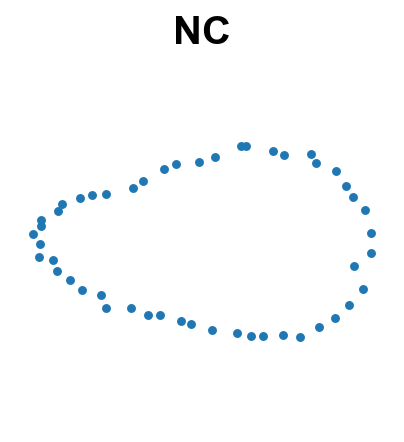

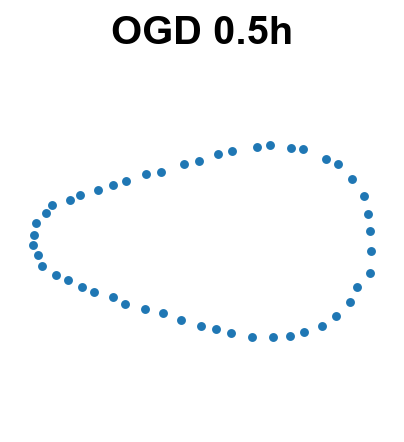

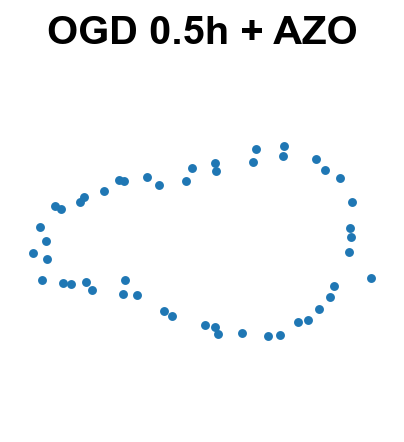

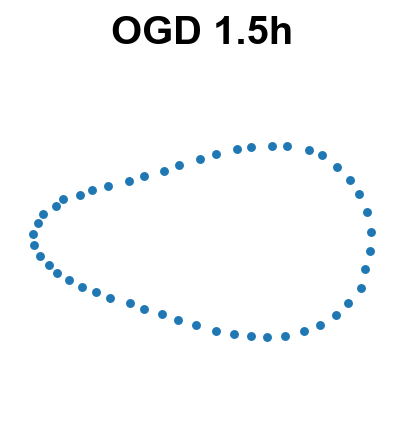

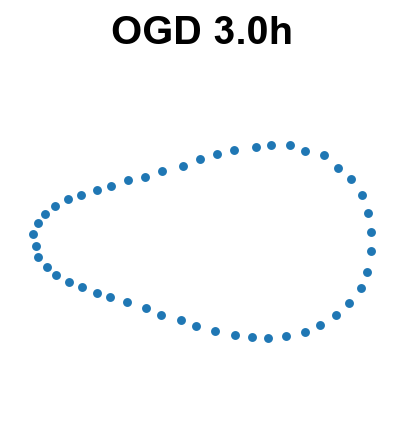

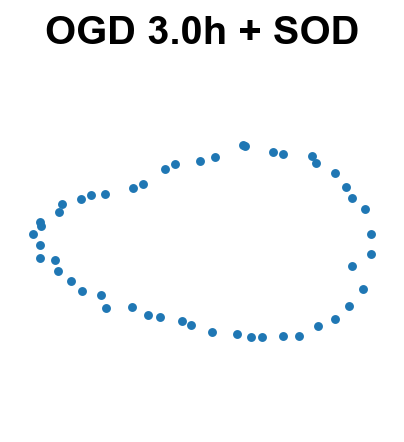

In [261]:
for i, treatment in enumerate(all_treatments):
    contour_plot = np.mean((principal_components @ principal_directions + mean_contour)[i*num_resample:(i+1)*num_resample, :], axis=0)
    mean_contour = vampire_model.mean_aligned_contour
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.plot(
        contour_plot[:50],
        contour_plot[50:],
        '.'
    )
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(treatment)
    plt.show()

(-1.3801165832491191,
 1.4808855780682222,
 -0.7888044986366739,
 0.8139185005855689)

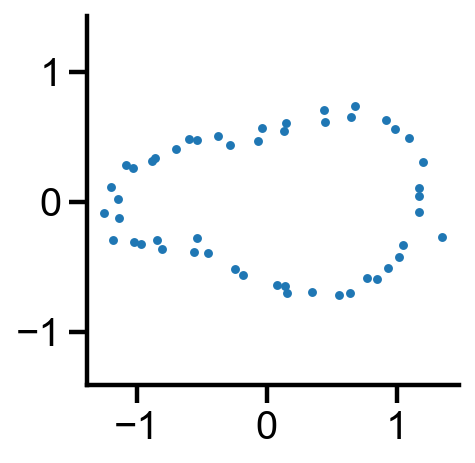

In [262]:
i = 500 * 2
mean_contour = vampire_model.mean_aligned_contour
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(
    (principal_components @ principal_directions + mean_contour)[i, :50],
    (principal_components @ principal_directions + mean_contour)[i, 50:],
    '.'
)
ax.axis('equal')

Text(0.5, 1.0, 'Rat OGD (x/n = 0.3)')

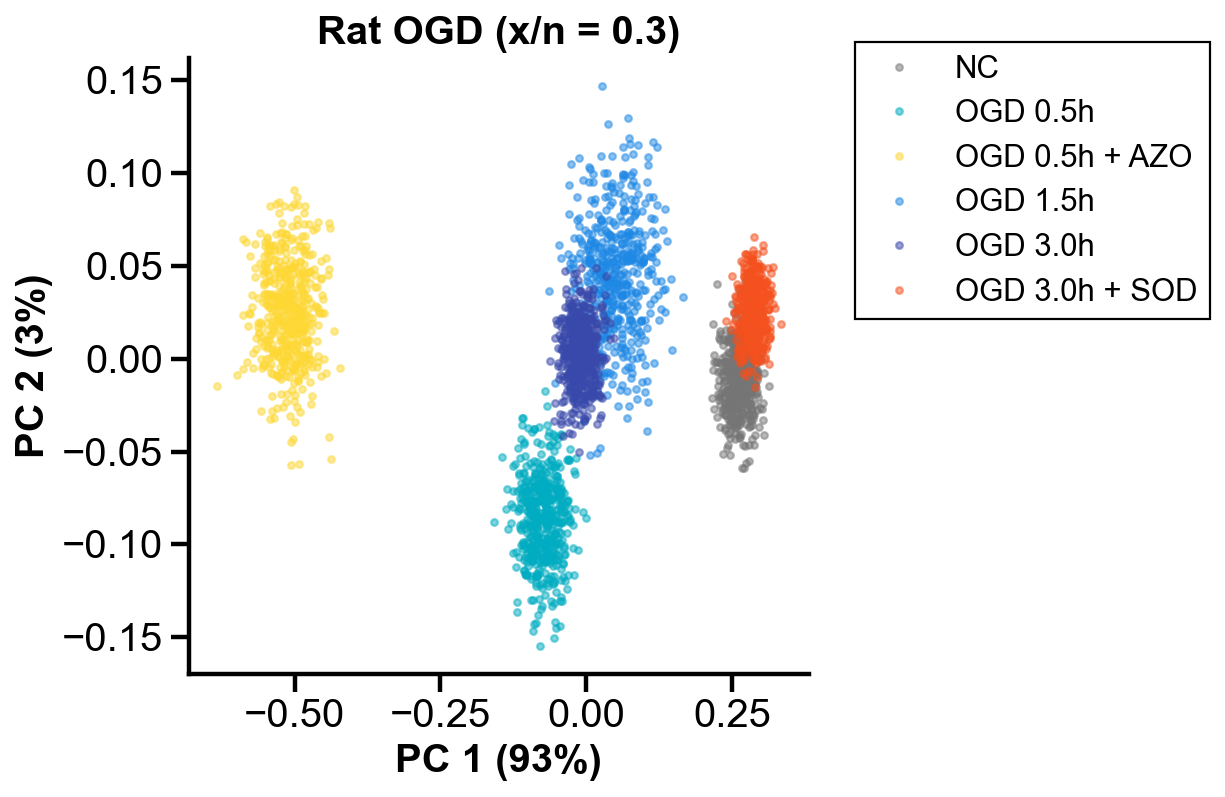

In [263]:
fig, ax = plt.subplots(figsize=(5, 5))
for n_treatment, treatment in enumerate(all_treatments):
    ax.plot(
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 0], 
        trunc_principal_components[n_treatment*num_resample:(n_treatment+1)*num_resample, 1],
        '.', alpha=0.5,
        c=all_mean_bootstrapped_treatment_contours_df['treatment_color'].iloc[n_treatment*num_resample],
        label=treatment,
    )
ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_xlabel(f"PC 1 ({round(explained_variance_ratio[0]*100)}%)")
ax.set_ylabel(f"PC 2 ({round(explained_variance_ratio[1]*100)}%)")
ax.set_title(f'Rat OGD (x/n = {subsample_ratio})')

Text(0.5, 1.0, 'Rat OGD (x/n = 0.3)')

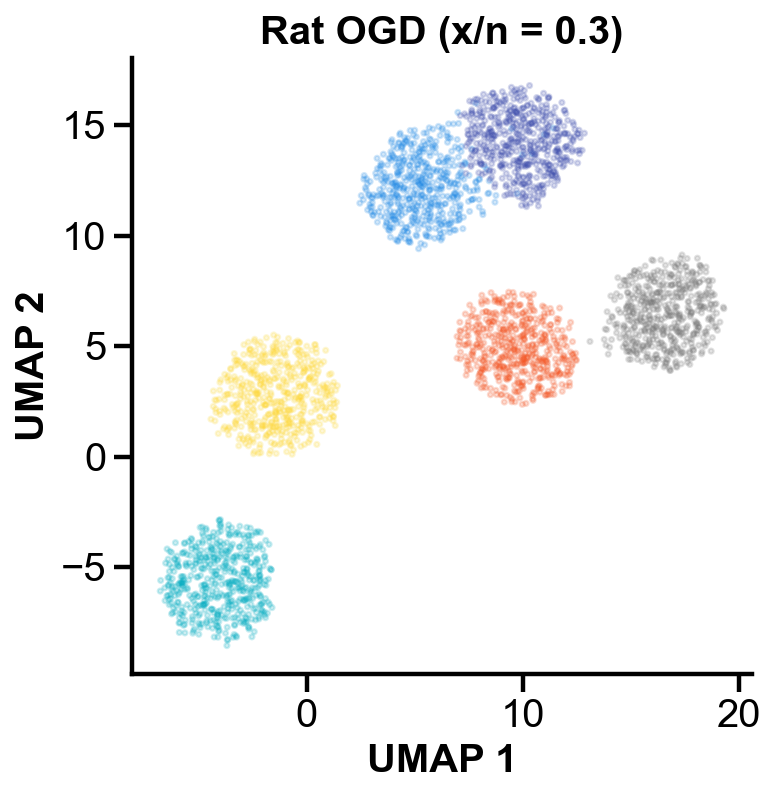

In [275]:
# UMAP
umap_reducer = umap.UMAP(n_neighbors=100, min_dist=1, spread=1, random_state=1)
umap_coords = umap_reducer.fit_transform(trunc_principal_components)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    umap_coords[:, 0], 
    umap_coords[:, 1], 
    s=5, alpha=0.2, 
    color=all_mean_bootstrapped_treatment_contours_df['treatment_color'],
    label=treatment,
)
# ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title(f'Rat OGD (x/n = {subsample_ratio})')

## UMAP separately

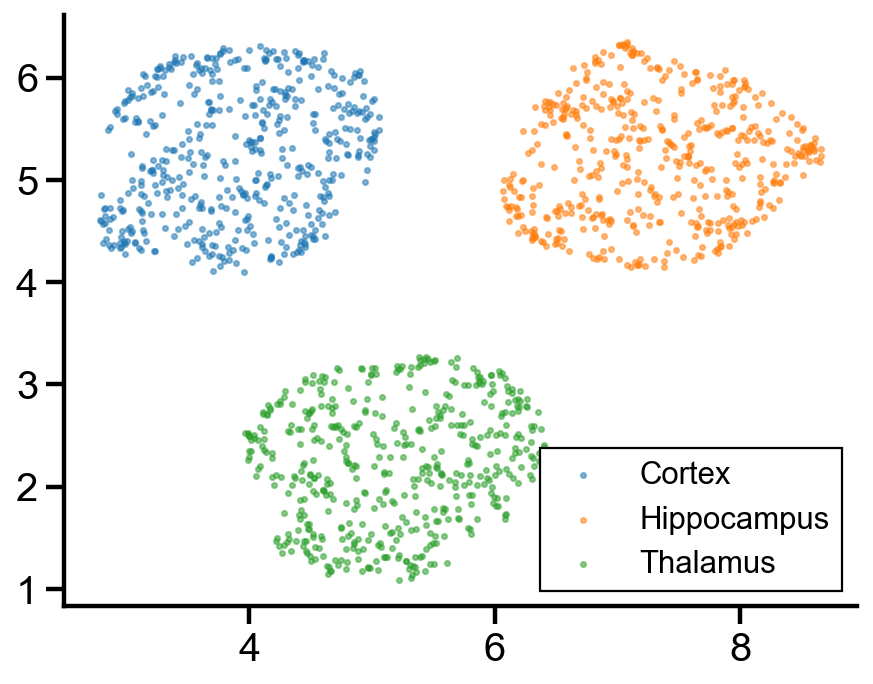

In [156]:
rng = default_rng(seed=1)
subsample_ratio = 0.3  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_regions = np.unique(apply_properties_df['region'])
for region in all_regions:
    region_cond = apply_properties_df['region'] == region
    mean_bootstrapped_region_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(region_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_region_contours = rng.choice(normalized_contours[region_cond], size=num_subsample, replace=False)
        mean_bootstrapped_region_contour = bootstrapped_region_contours.mean(axis=0)
        mean_bootstrapped_region_contours[n_resample, :] = mean_bootstrapped_region_contour
    # PCA bootstrapped contours
    principal_directions, principal_components, explained_variance = vp.amath.pca(mean_bootstrapped_region_contours)
    trunc_principal_components = principal_components[:, :num_pc]
    # UMAP
    umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0, spread=0.5, random_state=1)
    umap_coords = umap_reducer.fit_transform(trunc_principal_components)
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=5, alpha=0.5)
plt.legend(all_regions, bbox_to_anchor=(1.05, 1.05))

76
47
28
19
74
130


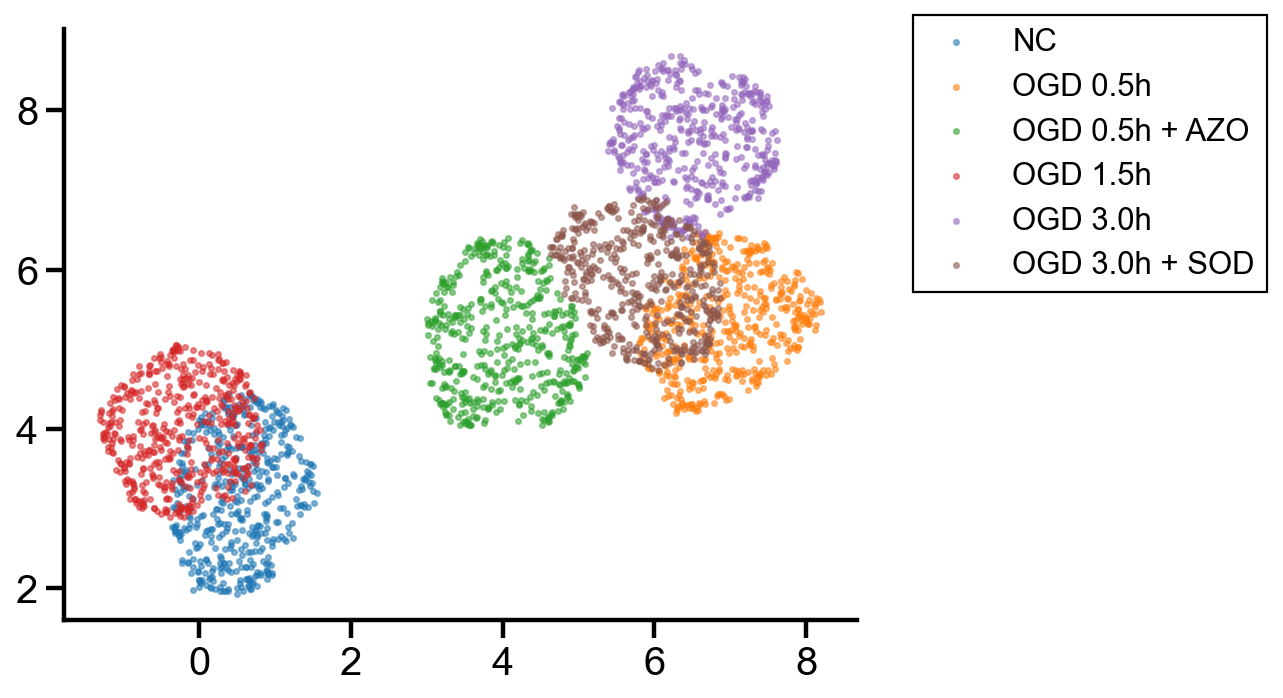

In [180]:
rng = default_rng(seed=1)
subsample_ratio = 0.01  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_treatments = np.unique(apply_properties_df['treatment'])
for treatment in all_treatments:
    treatment_cond = apply_properties_df['treatment'] == treatment
    mean_bootstrapped_treatment_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(treatment_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    print(num_subsample)
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_treatment_contours = rng.choice(normalized_contours[treatment_cond], size=num_subsample, replace=False)
        mean_bootstrapped_treatment_contour = bootstrapped_treatment_contours.mean(axis=0)
        mean_bootstrapped_treatment_contours[n_resample, :] = mean_bootstrapped_treatment_contour
    # PCA bootstrapped contours
    principal_directions, principal_components, explained_variance = vp.amath.pca(mean_bootstrapped_treatment_contours)
    trunc_principal_components = principal_components[:, :num_pc]
    # UMAP
    umap_reducer = umap.UMAP(n_neighbors=80, min_dist=0, spread=0.5, random_state=1)  # 50 (80), 0, 0.5 conflicting results
    umap_coords = umap_reducer.fit_transform(trunc_principal_components)
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=5, alpha=0.5)
plt.legend(all_treatments, bbox_to_anchor=(1.05, 1.05))

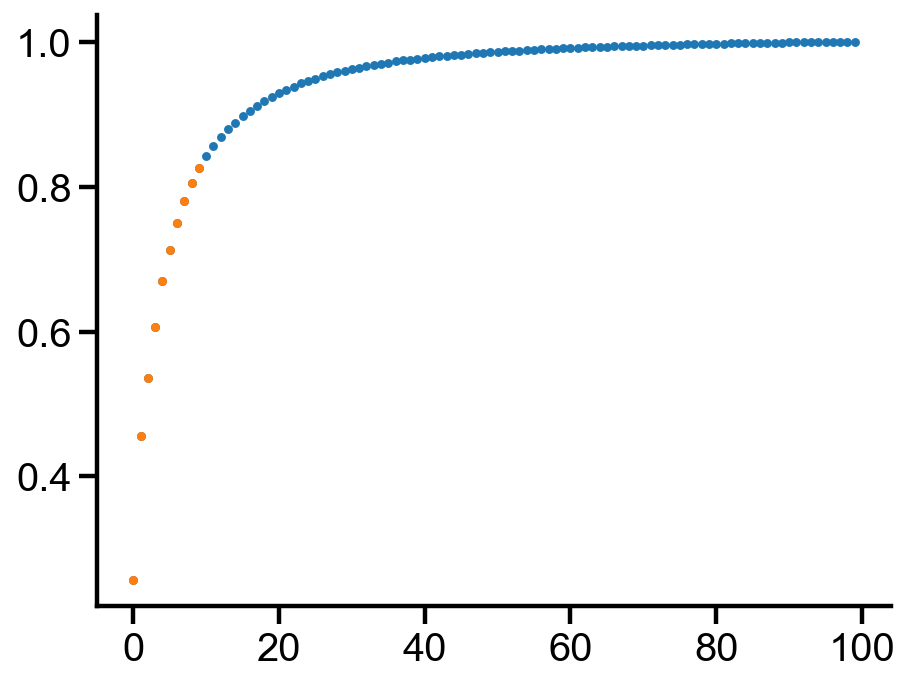

In [82]:
plt.plot(np.cumsum(explained_variance / np.sum(explained_variance)), '.')
plt.plot(np.cumsum(explained_variance / np.sum(explained_variance))[:10], '.')

## Bootstrapping features per condition before PCA

In [ ]:
props = apply_properties_df[
    [
        "area",
        "perimeter",
        "major_axis_length",
        "minor_axis_length",
        "eccentricity",
        "solidity",
        "extent",
        "circularity",
        "aspect_ratio",
    ]
]

In [ ]:
rng = default_rng(seed=1)
subsample_ratio = 0.3  # controls number of points that constitute a bootstrapped dataset
num_resample = 500  # number of bootstrapped dataset generated
num_pc = 10
all_regions = np.unique(apply_properties_df['region'])
for region in all_regions:
    region_cond = apply_properties_df['region'] == region
    mean_bootstrapped_region_contours = np.zeros((num_resample, 100))
    num_subsample = int(np.sum(region_cond) * subsample_ratio)  # number of points that constitute a bootstrapped dataset
    for n_resample in range(num_resample):
        # generate one bootstrapped dataset and calculate mean
        bootstrapped_region_contours = rng.choice(normalized_contours[region_cond], size=num_subsample, replace=False)
        mean_bootstrapped_region_contour = bootstrapped_region_contours.mean(axis=0)
        mean_bootstrapped_region_contours[n_resample, :] = mean_bootstrapped_region_contour
    # PCA bootstrapped contours
    principal_directions, principal_components, explained_variance = vp.amath.pca(mean_bootstrapped_region_contours)
    trunc_principal_components = principal_components[:, :num_pc]
    # UMAP
    umap_reducer = umap.UMAP(n_neighbors=50, min_dist=0, spread=0.5, random_state=1)
    umap_coords = umap_reducer.fit_transform(trunc_principal_components)
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=5, alpha=0.5)
plt.legend(all_regions, bbox_to_anchor=(1.05, 1.05))